In [2]:
import pandas as pd
import jieba
import numpy as np
from pathlib import Path
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM
import matplotlib.pyplot as plt
units = 32

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
mypath = Path("demo-chinese-text-classification-lstm-keras")

In [4]:
df=pd.read_csv(mypath/'C:\\text.csv',header=0, names = ['id','comment','sentiment'])
df.drop('id',axis=1, inplace=True)
df.head()

,comment,sentiment
0,影片很值得观看，很有意义,1.0
1,黄渤这种人电影看一部少一部。必须支持,1.0
2,很好看不错的,1.0
3,发的干活吧不回家,1.0
4,不错啊！感觉挺好,1.0


In [5]:
df['text'] = df.comment.apply(lambda x: " ".join(jieba.cut(x)))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.201 seconds.
Prefix dict has been built succesfully.


In [6]:
df.head()

,comment,sentiment,text
0,影片很值得观看，很有意义,1.0,影片 很 值得 观看 ， 很 有 意义
1,黄渤这种人电影看一部少一部。必须支持,1.0,黄渤 这种 人 电影 看 一部 少 一部 。 必须 支持
2,很好看不错的,1.0,很 好看 不错 的
3,发的干活吧不回家,1.0,发 的 干活 吧 不 回家
4,不错啊！感觉挺好,1.0,不错 啊 ！ 感觉 挺 好


In [7]:
df1 = df[['text', 'sentiment']]
df1.head()

,text,sentiment
0,影片 很 值得 观看 ， 很 有 意义,1.0
1,黄渤 这种 人 电影 看 一部 少 一部 。 必须 支持,1.0
2,很 好看 不错 的,1.0
3,发 的 干活 吧 不 回家,1.0
4,不错 啊 ！ 感觉 挺 好,1.0


In [8]:
maxlen = 100
max_words = 10000

In [9]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df.text)
sequences = tokenizer.texts_to_sequences(df.text)

In [10]:
sequences[:1]

[[144, 8, 72, 246, 1, 8, 19, 151]]

In [11]:
for sequence in sequences[:5]:
    print(len(sequence))

8
11
4
6
6


In [12]:
data = pad_sequences(sequences, maxlen=maxlen)

In [13]:
data

array([[  0,   0,   0, ...,   8,  19, 151],
       [  0,   0,   0, ...,   3, 515, 102],
       [  0,   0,   0, ...,   4,   9,   2],
       ...,
       [  0,   0,   0, ..., 181, 122, 101],
       [  0,   0,   0, ...,  13,  44, 210],
       [  0,   0,   0, ...,   1,   6,  32]])

In [14]:
word_index = tokenizer.word_index
print(word_index)

{'，': 1, '的': 2, '。': 3, '好看': 4, '了': 5, '不': 6, '！': 7, '很': 8, '不错': 9, '看': 10, '电影': 11, '还': 12, '我': 13, '是': 14, '好': 15, '…': 16, '都': 17, '可以': 18, '有': 19, '吧': 20, '人性': 21, '没': 22, '剧情': 23, '挺': 24, '没有': 25, '也': 26, '真的': 27, '太': 28, '就': 29, '一般': 30, '啊': 31, '喜欢': 32, '人': 33, '感觉': 34, '什么': 35, '黄渤': 36, '无聊': 37, '还是': 38, '渤': 39, '黄': 40, '垃圾': 41, '演技': 42, '去': 43, '想': 44, '在': 45, '失望': 46, '给': 47, '张艺兴': 48, '非常': 49, '和': 50, '？': 51, '搞笑': 52, '说': 53, '一部': 54, '一点': 55, '觉得': 56, '难看': 57, '有点': 58, '就是': 59, '没意思': 60, '让': 61, '烂片': 62, '演员': 63, '导演': 64, '一出': 65, '你': 66, '看不懂': 67, '这': 68, '这个': 69, '一个': 70, '知道': 71, '值得': 72, '好戏': 73, '、': 74, '但是': 75, '完': 76, '喜剧': 77, '还行': 78, '情节': 79, '睡着': 80, '不是': 81, '意思': 82, '一般般': 83, '中': 84, '但': 85, '超级': 86, '还好': 87, '～': 88, '烂': 89, '多': 90, '演': 91, '要': 92, '这部': 93, '走': 94, '很多': 95, '他': 96, '看到': 97, '不好': 98, '片子': 99, '表达': 100, '钱': 101, '支持': 102, '出来': 103, '行': 104, '推荐': 1

In [15]:
labels = np.array(df.sentiment)
labels

array([1., 1., 1., ..., 0., 0., 0.])

In [16]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices] 
labels = labels[indices]

In [17]:
training_samples = int(len(indices) * 0.8)
validation_samples = len(indices) - training_samples

In [18]:
X_train = data[:training_samples]
y_train = labels[:training_samples]
X_valid = data[training_samples: training_samples + validation_samples]
y_valid = labels[training_samples: training_samples + validation_samples]

In [19]:
myzip = mypath / 'zh.zip'

In [20]:
zh_model = KeyedVectors.load_word2vec_format('zh.vec')

In [21]:
zh_model.vectors[0]

array([ 8.6988e-02,  9.1123e-02,  3.0722e-02,  3.4160e-03,  2.7568e-02,
        5.4995e-03,  1.0905e-01,  4.9999e-02, -1.9161e-01,  4.2729e-02,
        1.3284e-01, -4.2997e-02,  4.4196e-02, -4.6042e-02,  5.2395e-02,
       -1.3002e-01,  1.1440e-01, -1.5359e-01,  5.7565e-02,  1.3344e-01,
       -6.4197e-02,  5.3679e-02,  1.3349e-01,  6.1268e-02, -2.4911e-03,
        1.9382e-01,  4.4253e-02, -2.0858e-02, -8.0714e-02,  1.0053e-01,
        5.8553e-02,  6.3155e-02, -2.9961e-02, -3.1906e-02,  5.6153e-02,
        5.1014e-02,  1.0752e-01, -7.4407e-02,  9.1990e-02,  1.7744e-01,
       -5.9959e-02,  1.4046e-01, -8.0201e-02,  4.3989e-02, -9.5205e-02,
        1.3022e-02,  9.1900e-02,  2.4317e-02, -7.0992e-02, -1.5179e-01,
       -3.0031e-02,  1.0344e-01, -5.8155e-02,  3.5950e-02, -5.5085e-02,
        4.7587e-02, -1.4251e-01, -1.3986e-01, -1.3891e-01,  6.9042e-03,
        9.0945e-02, -5.5156e-02,  6.8180e-02,  1.1948e-01,  7.8577e-03,
        1.0014e-01, -4.2805e-02,  2.2362e-01, -2.6212e-02, -3.53

In [22]:
list(iter(zh_model.vocab))[:5]

['的', '</s>', '在', '是', '年']

In [23]:
len(zh_model[next(iter(zh_model.vocab))])

300

In [24]:
embedding_dim = len(zh_model[next(iter(zh_model.vocab))])

In [25]:
embedding_matrix = np.random.rand(max_words, embedding_dim)

In [26]:
embedding_matrix

array([[0.96460796, 0.41158055, 0.51116454, ..., 0.38751088, 0.13893355,
        0.55054864],
       [0.42026467, 0.73549539, 0.48344585, ..., 0.60866241, 0.87603375,
        0.23627766],
       [0.51600487, 0.48579776, 0.36446463, ..., 0.59523619, 0.58699223,
        0.95273442],
       ...,
       [0.02033366, 0.97506549, 0.61999772, ..., 0.27070109, 0.89203814,
        0.67646655],
       [0.16969004, 0.82369823, 0.92839171, ..., 0.21480603, 0.76644391,
        0.99179449],
       [0.86189151, 0.887686  , 0.55620752, ..., 0.44733025, 0.11187668,
        0.42682649]])

In [27]:
embedding_matrix = (embedding_matrix - 0.5) * 2

In [28]:
embedding_matrix

array([[ 0.92921591, -0.1768389 ,  0.02232909, ..., -0.22497825,
        -0.72213289,  0.10109728],
       [-0.15947067,  0.47099078, -0.03310829, ...,  0.21732481,
         0.7520675 , -0.52744467],
       [ 0.03200975, -0.02840448, -0.27107075, ...,  0.19047237,
         0.17398447,  0.90546883],
       ...,
       [-0.95933268,  0.95013099,  0.23999544, ..., -0.45859782,
         0.78407628,  0.3529331 ],
       [-0.66061991,  0.64739646,  0.85678343, ..., -0.57038794,
         0.53288781,  0.98358898],
       [ 0.72378302,  0.775372  ,  0.11241504, ..., -0.1053395 ,
        -0.77624665, -0.14634702]])

In [29]:
zh_model.get_vector('的')

array([ 8.6988e-02,  9.1123e-02,  3.0722e-02,  3.4160e-03,  2.7568e-02,
        5.4995e-03,  1.0905e-01,  4.9999e-02, -1.9161e-01,  4.2729e-02,
        1.3284e-01, -4.2997e-02,  4.4196e-02, -4.6042e-02,  5.2395e-02,
       -1.3002e-01,  1.1440e-01, -1.5359e-01,  5.7565e-02,  1.3344e-01,
       -6.4197e-02,  5.3679e-02,  1.3349e-01,  6.1268e-02, -2.4911e-03,
        1.9382e-01,  4.4253e-02, -2.0858e-02, -8.0714e-02,  1.0053e-01,
        5.8553e-02,  6.3155e-02, -2.9961e-02, -3.1906e-02,  5.6153e-02,
        5.1014e-02,  1.0752e-01, -7.4407e-02,  9.1990e-02,  1.7744e-01,
       -5.9959e-02,  1.4046e-01, -8.0201e-02,  4.3989e-02, -9.5205e-02,
        1.3022e-02,  9.1900e-02,  2.4317e-02, -7.0992e-02, -1.5179e-01,
       -3.0031e-02,  1.0344e-01, -5.8155e-02,  3.5950e-02, -5.5085e-02,
        4.7587e-02, -1.4251e-01, -1.3986e-01, -1.3891e-01,  6.9042e-03,
        9.0945e-02, -5.5156e-02,  6.8180e-02,  1.1948e-01,  7.8577e-03,
        1.0014e-01, -4.2805e-02,  2.2362e-01, -2.6212e-02, -3.53

In [30]:
for word, i in word_index.items():
    if i < max_words:
        try:
            embedding_vector = zh_model.get_vector(word)
            embedding_matrix[i] = embedding_vector
        except:
            pass

In [31]:
embedding_matrix

array([[ 0.92921591, -0.1768389 ,  0.02232909, ..., -0.22497825,
        -0.72213289,  0.10109728],
       [-0.15947067,  0.47099078, -0.03310829, ...,  0.21732481,
         0.7520675 , -0.52744467],
       [ 0.086988  ,  0.091123  ,  0.030722  , ...,  0.1095    ,
        -0.053695  ,  0.033823  ],
       ...,
       [-0.95933268,  0.95013099,  0.23999544, ..., -0.45859782,
         0.78407628,  0.3529331 ],
       [-0.66061991,  0.64739646,  0.85678343, ..., -0.57038794,
         0.53288781,  0.98358898],
       [ 0.72378302,  0.775372  ,  0.11241504, ..., -0.1053395 ,
        -0.77624665, -0.14634702]])

In [32]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim))
model.add(LSTM(units))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                42624     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 3,042,657
Trainable params: 3,042,657
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [34]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_valid, y_valid))
model.save("mymodel.h5")

Train on 1597 samples, validate on 400 samples
Epoch 1/10
1597/1597 [==============================] - 6s 4ms/step - loss: 0.6463 - acc: 0.6343 - val_loss: 0.5674 - val_acc: 0.7600
Epoch 2/10
1597/1597 [==============================] - 4s 2ms/step - loss: 0.4791 - acc: 0.7940 - val_loss: 0.4513 - val_acc: 0.8200
Epoch 3/10
1597/1597 [==============================] - 4s 2ms/step - loss: 0.3755 - acc: 0.8491 - val_loss: 0.4080 - val_acc: 0.8300
Epoch 4/10
1597/1597 [==============================] - 4s 2ms/step - loss: 0.3157 - acc: 0.8748 - val_loss: 0.4023 - val_acc: 0.8450
Epoch 5/10
1597/1597 [==============================] - 4s 2ms/step - loss: 0.2764 - acc: 0.8967 - val_loss: 0.4484 - val_acc: 0.8225
Epoch 6/10
1597/1597 [==============================] - 4s 2ms/step - loss: 0.2444 - acc: 0.9061 - val_loss: 0.3907 - val_acc: 0.8500
Epoch 7/10
1597/1597 [==============================] - 4s 2ms/step - loss: 0.2246 - acc: 0.9205 - val_loss: 0.3890 - val_acc: 0.8500
Epoch 8/10
1597

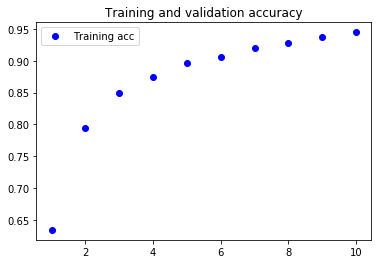

<Figure size 432x288 with 0 Axes>

In [36]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.show()

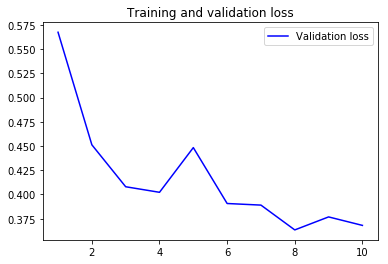

In [39]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()